#### Module 1

In [1]:
from pathlib import Path

parent_dir = Path().resolve().parent 
data_path = parent_dir/"data/module1"   
result_path = parent_dir/"results/module1" 
result_path.mkdir(exist_ok=True)

##### Exercise 1.1

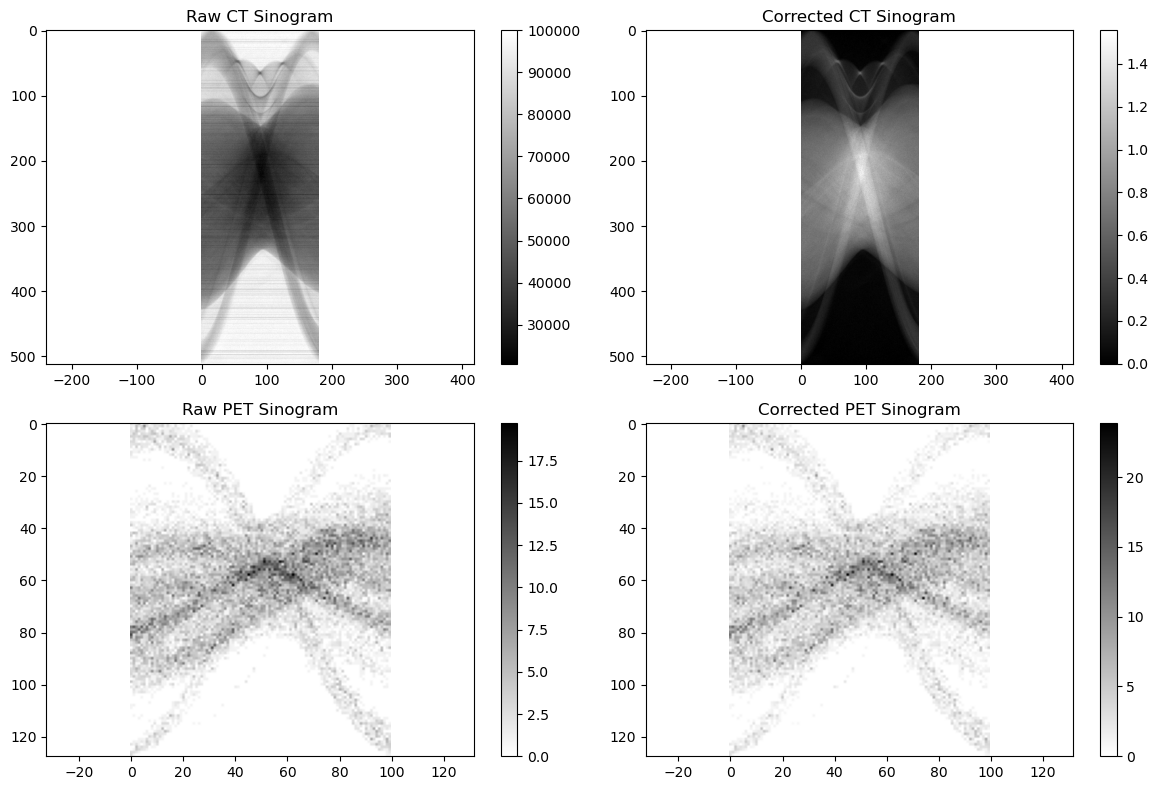

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from a2cw import correct_ct, correct_pet

ct_sino = np.load(data_path/"ct_sinogram.npy")
pet_sino = np.load(data_path/"pet_sinogram.npy")

ct_dark = np.load(data_path/"ct_dark.npy")
ct_flat = np.load(data_path/"ct_flat.npy")
pet_calibration = np.load(data_path/"pet_calibration.npy")

ct_sino_corrected = correct_ct(ct_sino, ct_dark, ct_flat)
pet_sino_corrected = correct_pet(pet_sino, pet_calibration)

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(ct_sino, cmap="gray")
plt.title("Raw CT Sinogram")
plt.colorbar()
plt.axis("equal")

plt.subplot(222)
plt.imshow(ct_sino_corrected, cmap="gray")
plt.title("Corrected CT Sinogram")
plt.colorbar()
plt.axis("equal")

plt.subplot(223)
plt.imshow(pet_sino, cmap="gray_r") 
plt.title("Raw PET Sinogram")
plt.colorbar()
plt.axis("equal")

plt.subplot(224)
plt.imshow(pet_sino_corrected, cmap="gray_r")
plt.title("Corrected PET Sinogram")
plt.colorbar()
plt.axis("equal")

plt.tight_layout()
plt.show()

np.save(result_path/"ct_sino_corrected.npy", ct_sino_corrected)
np.save(result_path/"pet_sino_corrected.npy", pet_sino_corrected)

##### Exercise 1.2

OS-SART complete the iteration 5/20
OS-SART complete the iteration 10/20
OS-SART complete the iteration 15/20
OS-SART complete the iteration 20/20
SIRT complete the iteration 5/10
SIRT complete the iteration 10/10


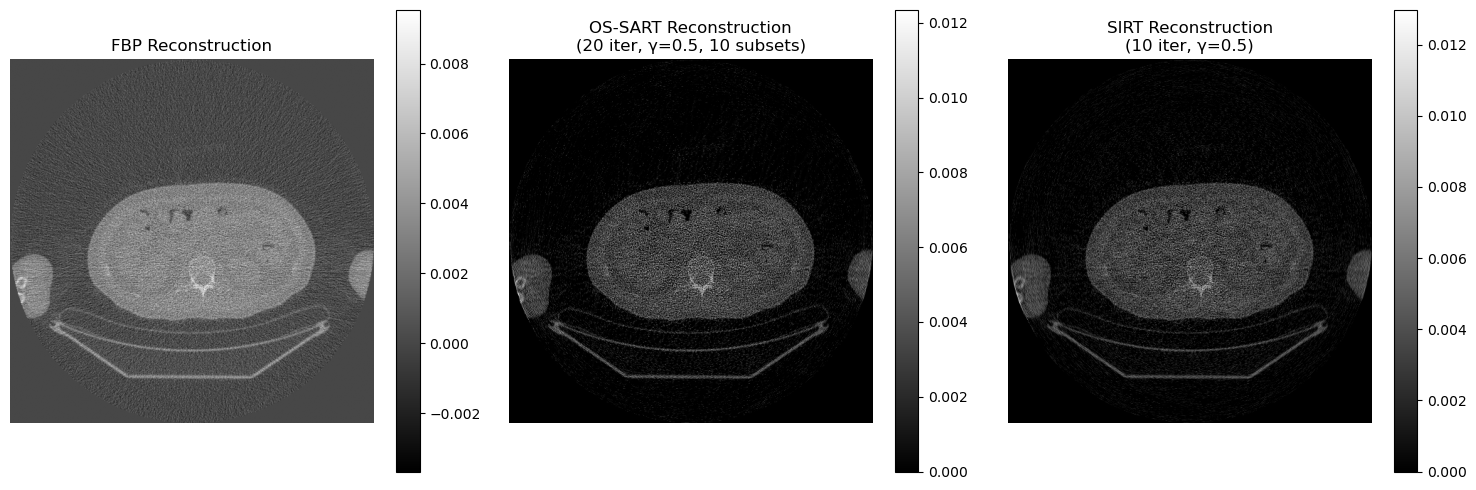


Evaluate the quality of reconstruction (relative to FBP):
RMSE of OS-SART: 0.000713
RMSE of SIRT: 0.000616
SSIM of OS-SART: 0.594365
SSIM of SIRT: 0.639157


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from a2cw import fbp, os_sart, sirt

ct_sino_corrected = np.load(result_path/"ct_sino_corrected.npy")

theta = np.linspace(0, 180, 180, endpoint=False)

fbp_im = fbp(ct_sino_corrected, theta)
os_sart_im = os_sart(ct_sino_corrected, theta, n_iter=20, n_subset=10, relaxation=0.5)                                     
sirt_im = sirt(ct_sino_corrected, theta, n_iter=10, relaxation=0.5)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(fbp_im, cmap='gray')
plt.title('FBP Reconstruction')
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.imshow(os_sart_im, cmap='gray')
plt.title('OS-SART Reconstruction\n(20 iter, γ=0.5, 10 subsets)')
plt.colorbar()
plt.axis('off')

plt.subplot(133)
plt.imshow(sirt_im, cmap='gray')
plt.title('SIRT Reconstruction\n(10 iter, γ=0.5)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


# calculate metrics (relative to FBP)
rmse_os_sart = np.sqrt(np.mean((fbp_im - os_sart_im) ** 2))
rmse_sirt = np.sqrt(np.mean((fbp_im - sirt_im) ** 2))

print(f"\nEvaluate the quality of reconstruction (relative to FBP):")
print(f"RMSE of OS-SART: {rmse_os_sart:.6f}")
print(f"RMSE of SIRT: {rmse_sirt:.6f}")

data_range = fbp_im.max() - fbp_im.min()
ssim_os_sart = ssim(fbp_im, os_sart_im, data_range=data_range)
ssim_sirt = ssim(fbp_im, sirt_im, data_range=data_range)
print(f"SSIM of OS-SART: {ssim_os_sart:.6f}")
print(f"SSIM of SIRT: {ssim_sirt:.6f}")

np.save(result_path/"ct_fbp.npy", fbp_im)
np.save(result_path/"ct_os_sart.npy", os_sart_im)


Ex1.3

c:\Users\X13\.conda\envs\a2cw\lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


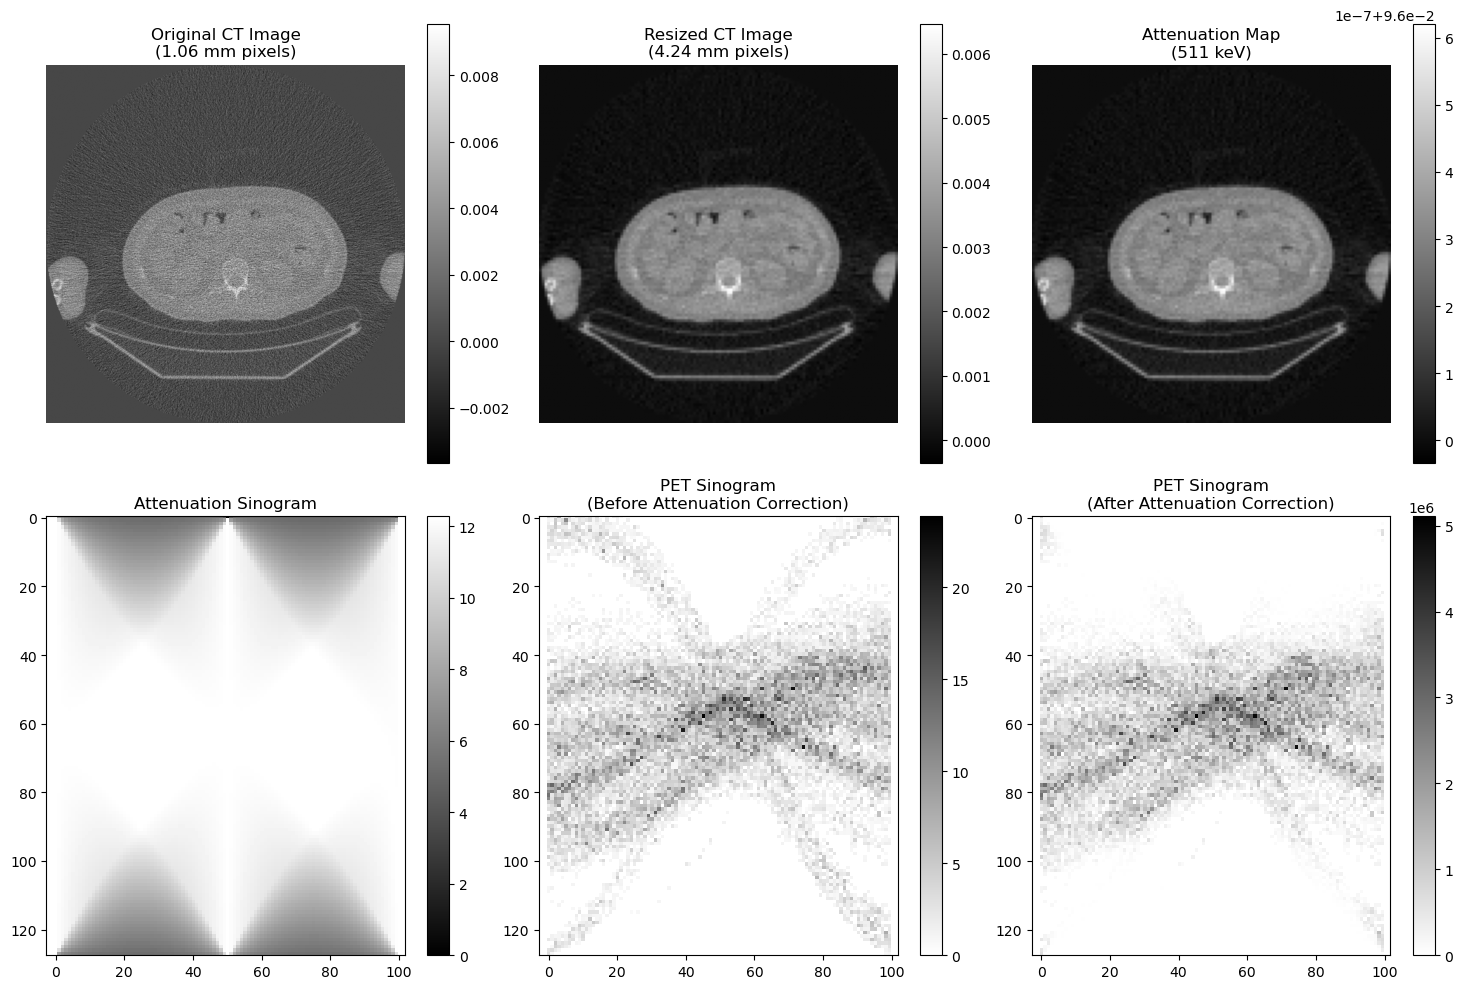

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from a2cw import resize_ct, attenuation_map, attenuation_sino, attenuation_corr

ct_recons = np.load(result_path/"ct_fbp.npy") 
pet_corrected = np.load(result_path/"pet_sino_corrected.npy")

ct_resized = resize_ct(ct_recons)

attenu = attenuation_map(ct_resized)

attenu_sino = attenuation_sino(attenu, pet_corrected.shape)

pet_sino_attn_corrected = attenuation_corr(pet_corrected, attenu_sino)


plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(ct_recons, cmap='gray')
plt.title('Original CT Image\n(1.06 mm pixels)')
plt.colorbar()
plt.axis('off')

plt.subplot(232)
plt.imshow(ct_resized, cmap='gray')
plt.title('Resized CT Image\n(4.24 mm pixels)')
plt.colorbar()
plt.axis('off')

plt.subplot(233)
plt.imshow(attenu, cmap='gray')
plt.title('Attenuation Map\n(511 keV)')
plt.colorbar()
plt.axis('off')

plt.subplot(234)
plt.imshow(attenu_sino, cmap='gray')
plt.title('Attenuation Sinogram')
plt.colorbar()
plt.axis('equal')

plt.subplot(235)
plt.imshow(pet_corrected, cmap='gray_r')
plt.title('PET Sinogram\n(Before Attenuation Correction)')
plt.colorbar()
plt.axis('equal')

plt.subplot(236)
plt.imshow(pet_sino_attn_corrected, cmap='gray_r')
plt.title('PET Sinogram\n(After Attenuation Correction)')
plt.colorbar()
plt.axis('equal')

plt.tight_layout()
plt.show()

np.save(result_path/"pet_sino_attn_corrected.npy", pet_sino_attn_corrected)

Ex1.4

FBP reconstruction time: 0.01s
OSEM reconstruction time: 0.17s
MLEM reconstruction time: 0.79s


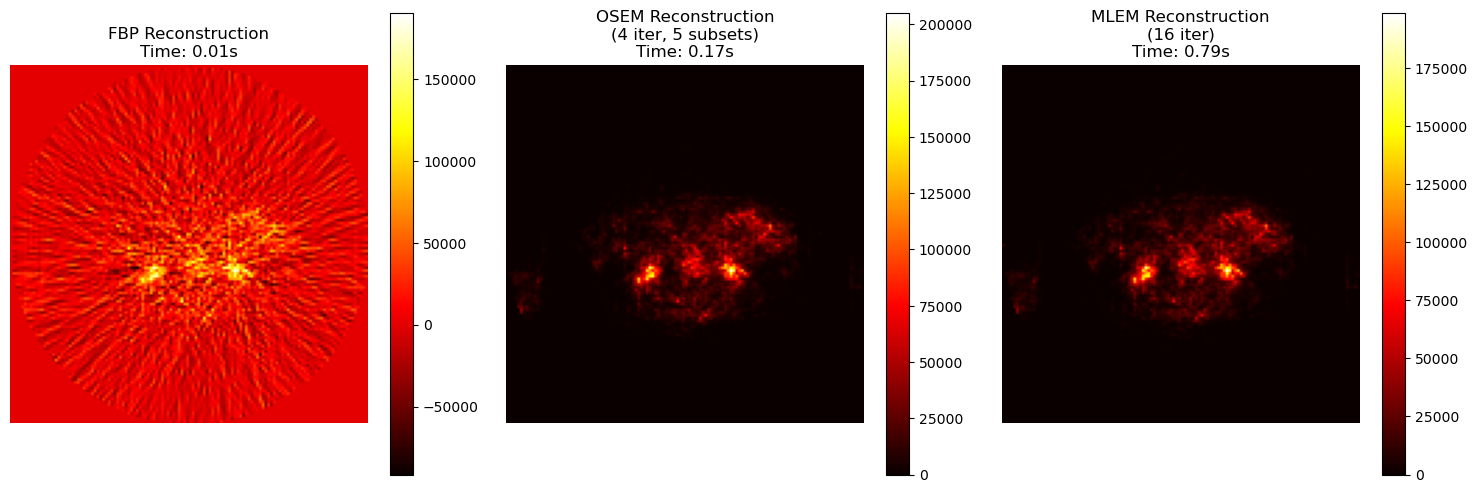

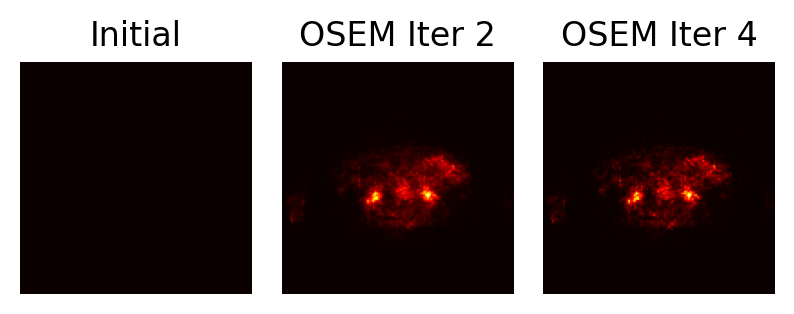

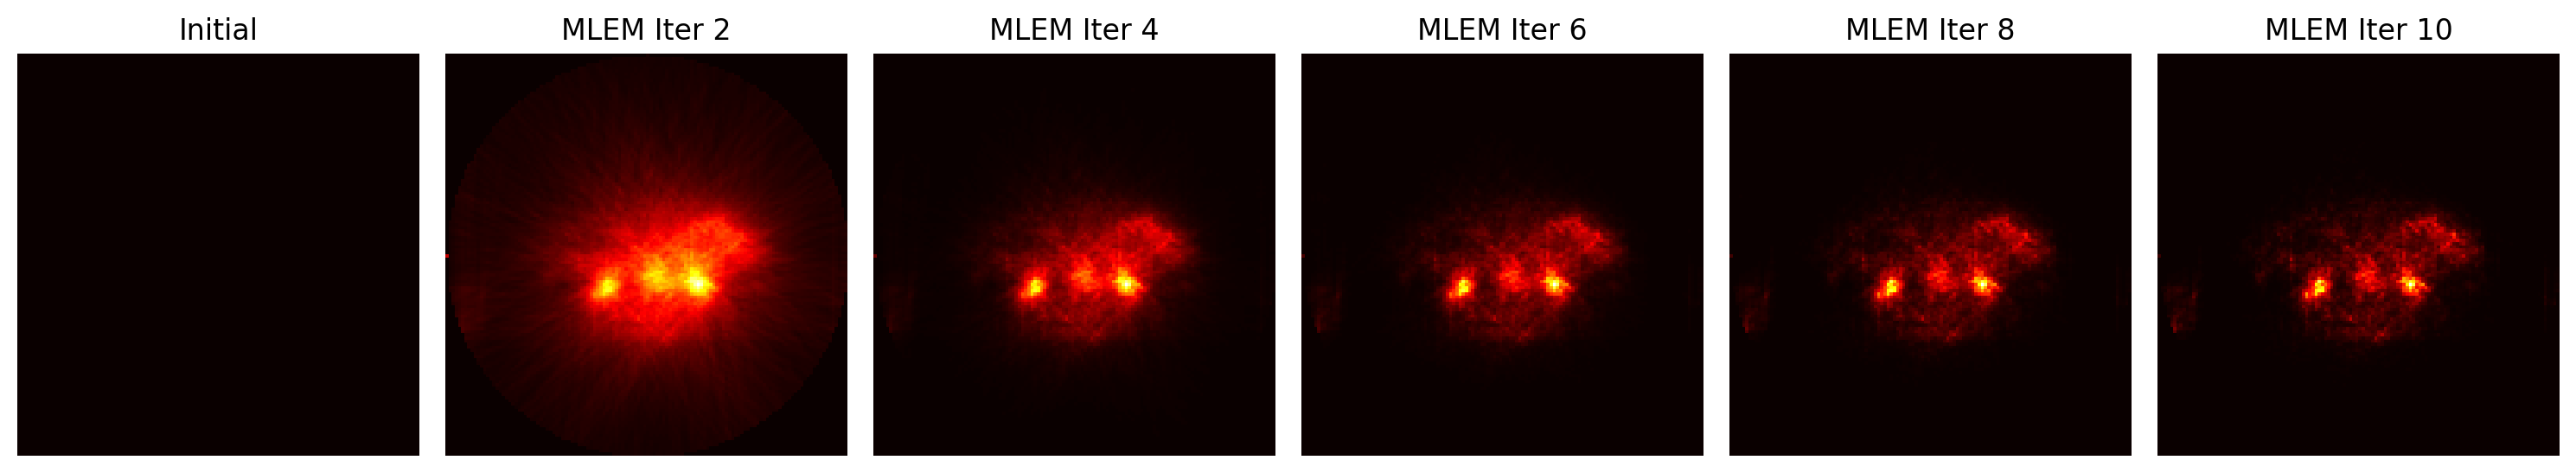

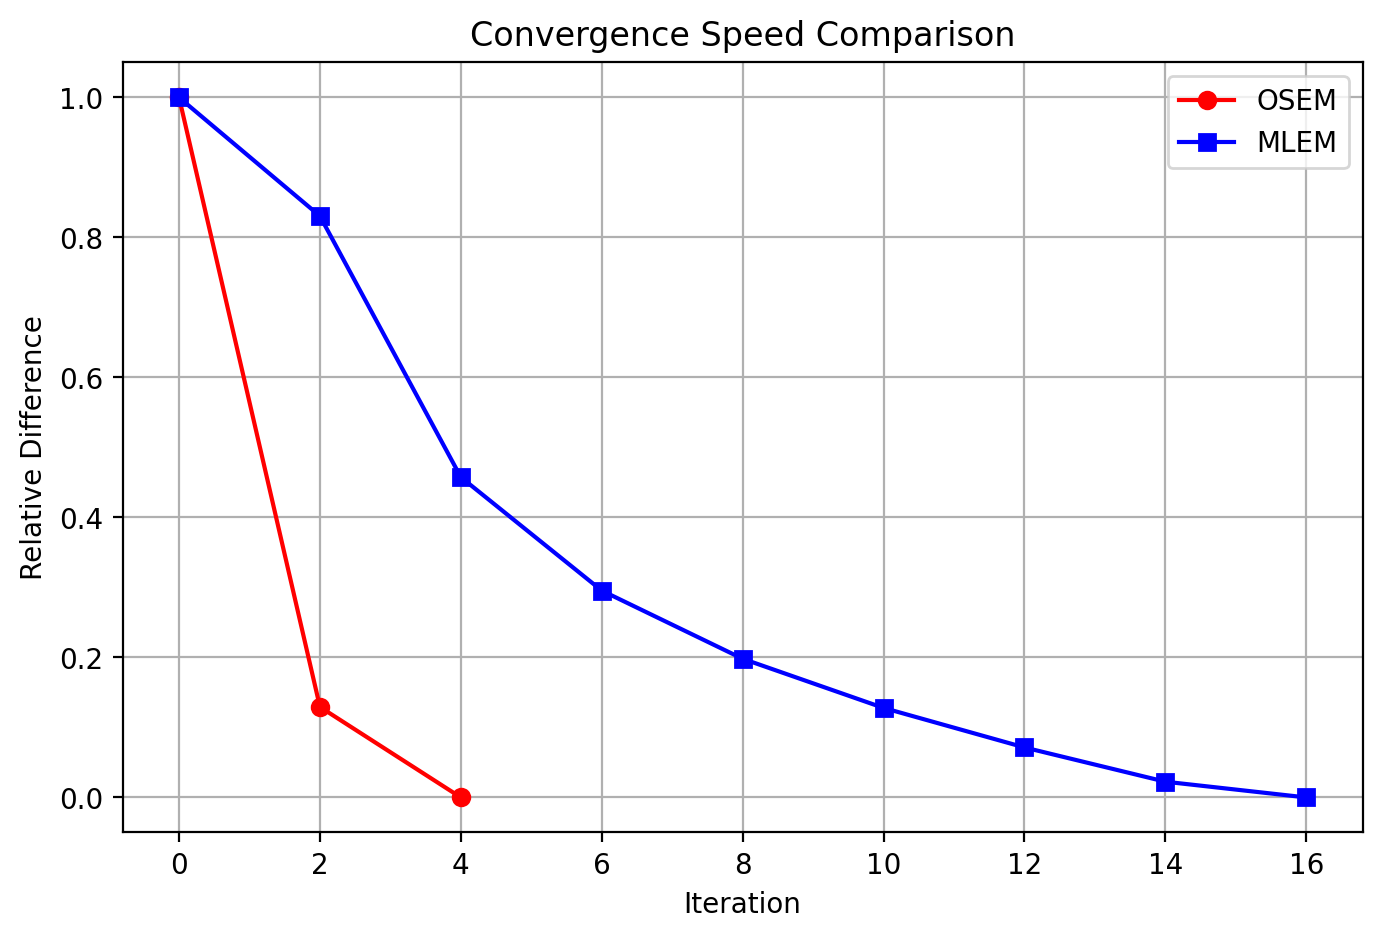

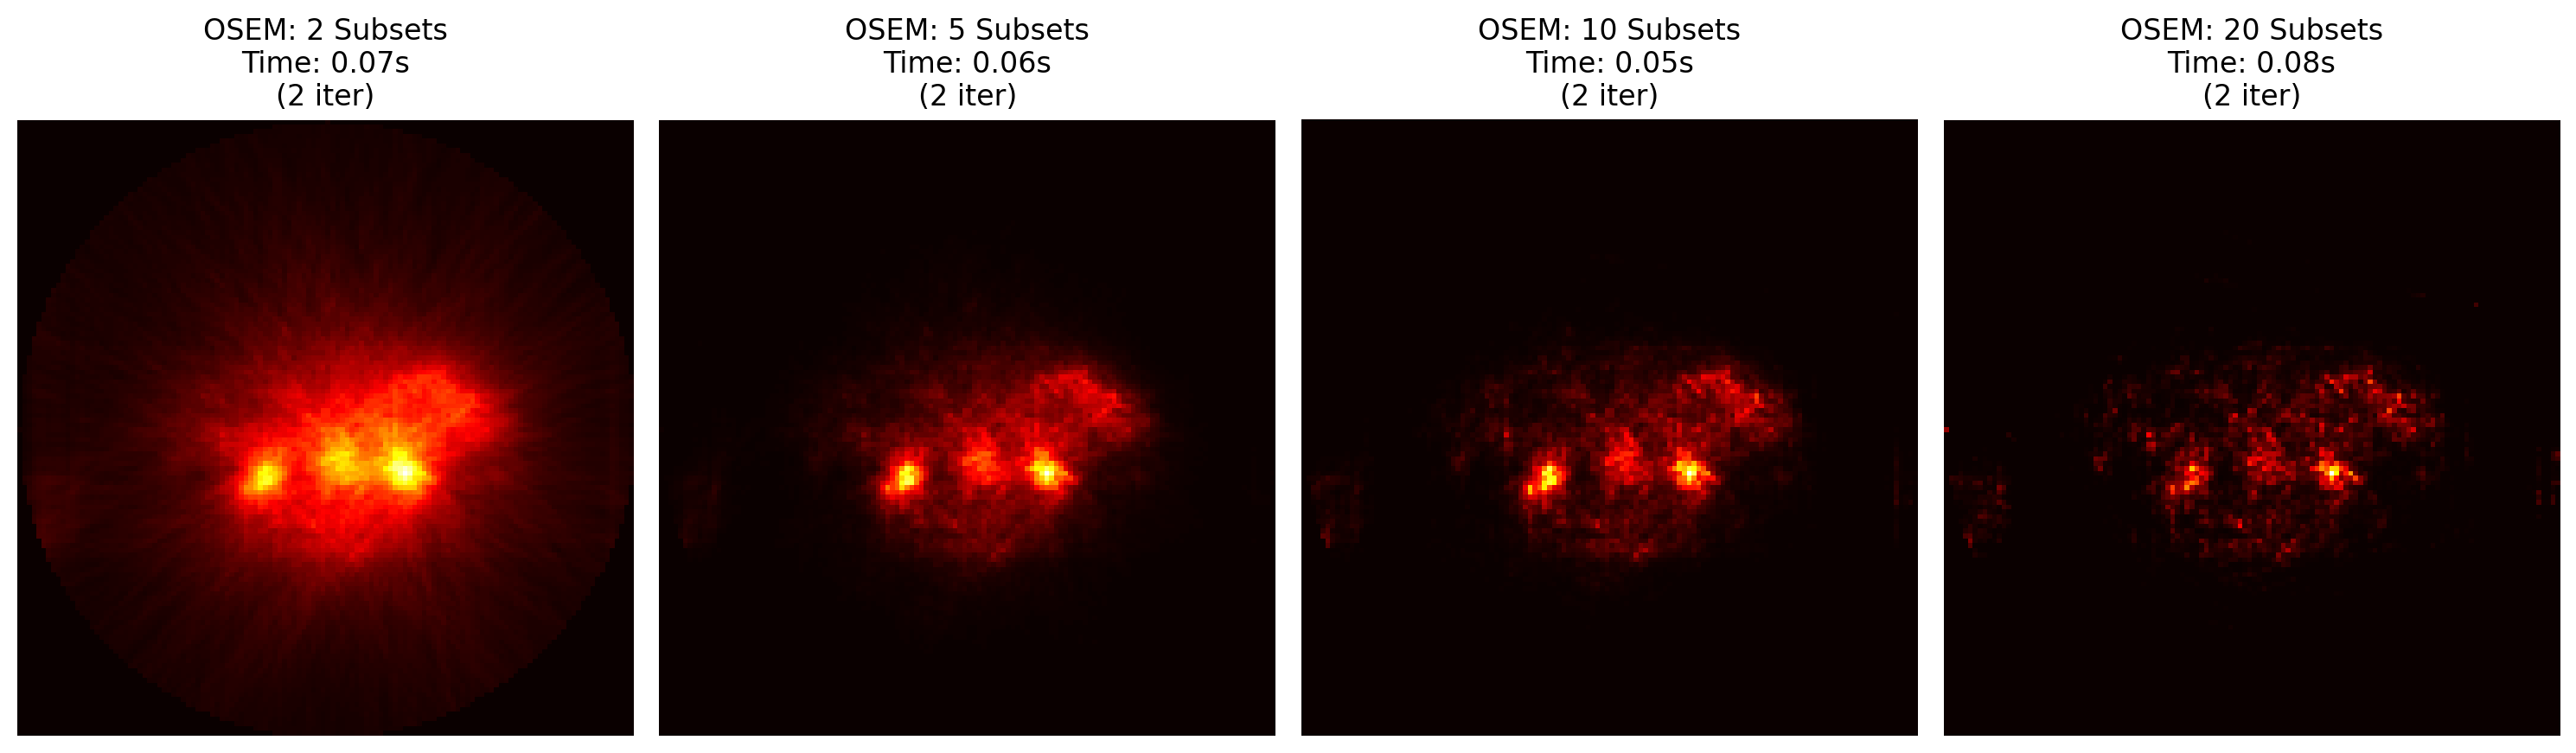

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

from a2cw import fbp, osem, mlem

pet_sino_attn_corrected = np.load(result_path/"pet_sino_attn_corrected.npy")

theta = np.linspace(0, 180, 100, endpoint=False)

start_time = time.time()
fbp_image = fbp(pet_sino_attn_corrected, theta)
fbp_time = time.time() - start_time
print(f"FBP reconstruction time: {fbp_time:.2f}s")

# OSEM
start_time = time.time()
osem_image, osem_interme = osem(
    pet_sino_attn_corrected, 
    theta=theta,
    n_iter=3,
    n_subset=5
)
osem_time = time.time() - start_time
print(f"OSEM reconstruction time: {osem_time:.2f}s")

# MLEM
start_time = time.time()
mlem_image, mlem_interme = mlem(
    pet_sino_attn_corrected, 
    n_iter=15
)
mlem_time = time.time() - start_time
print(f"MLEM reconstruction time: {mlem_time:.2f}s")


plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(fbp_image, cmap='hot')
plt.title(f'FBP Reconstruction\nTime: {fbp_time:.2f}s')
plt.colorbar()
plt.axis('off')

plt.subplot(132)
plt.imshow(osem_image, cmap='hot')
plt.title(f'OSEM Reconstruction\n(4 iter, 5 subsets)\nTime: {osem_time:.2f}s')
plt.colorbar()
plt.axis('off')

plt.subplot(133)
plt.imshow(mlem_image, cmap='hot')
plt.title(f'MLEM Reconstruction\n(16 iter)\nTime: {mlem_time:.2f}s')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

## -------------------- convergence speed comparison -------------------- ##
# OSEM convergence
plt.figure(figsize=(8, 5), dpi=200)
for i, img in enumerate(osem_interme):
    if i < 6: 
        plt.subplot(1, 6, i+1)
        plt.imshow(img, cmap='hot')
        if i == 0:
            plt.title('Initial')
        else:
            plt.title(f'OSEM Iter {i*2}')
        plt.axis('off')
plt.tight_layout()
plt.show()

# MLEM convergence
plt.figure(figsize=(15, 10), dpi=200)
for i, img in enumerate(mlem_interme):
    if i < 6:
        plt.subplot(1, 6, i+1)
        plt.imshow(img, cmap='hot')
        if i == 0:
            plt.title('Initial')
        else:
            plt.title(f'MLEM Iter {i*2}')
        plt.axis('off')
plt.tight_layout()
plt.show()

np.save(result_path/"pet_reconstruction_fbp.npy", fbp_image)
np.save(result_path/"pet_reconstruction_osem.npy", osem_image)
np.save(result_path/"pet_reconstruction_mlem.npy", mlem_image)

# compare the convergence speed of OSEM and MLEM
def relative_difference(image, reference):
    """Calculate the relative difference between the image and the reference."""
    return np.sum(np.abs(image - reference)) / np.sum(np.abs(reference))

# calculate the difference between intermediate OSEM results and final OSEM results
osem_differences = [relative_difference(img, osem_image) for img in osem_interme]      

# calculate the difference between intermediate MLEM results and final MLEM results
mlem_differences = [relative_difference(img, mlem_image) for img in mlem_interme]
                  
plt.figure(figsize=(8, 5),dpi=200)
plt.plot([2*i for i in range(len(osem_differences))], osem_differences, 'r-o', label='OSEM')
plt.plot([2*i for i in range(len(mlem_differences))], mlem_differences, 'b-s', label='MLEM')
plt.xlabel('Iteration')
plt.ylabel('Relative Difference')
plt.title('Convergence Speed Comparison')
plt.legend()
plt.grid(True)
plt.show()

## -------------------- OSEM with different number of subsets -------------------- ##
subsets = [2, 5, 10, 20]
osem_results = {}

for subset in subsets:
    start_time = time.time()
    result, _ = osem(
        pet_sino_attn_corrected, 
        n_iter=1,  
        n_subset=subset
    )
    elapsed = time.time() - start_time
    osem_results[subset] = {"image": result, "time": elapsed}

plt.figure(figsize=(15, 5), dpi=200)
for i, subset in enumerate(subsets):
    plt.subplot(1, len(subsets), i+1)
    plt.imshow(osem_results[subset]["image"], cmap='hot')
    plt.title(f'OSEM: {subset} Subsets\nTime: {osem_results[subset]["time"]:.2f}s\n(2 iter)')
    plt.axis('off')

plt.tight_layout()
plt.show()

Ex1.5

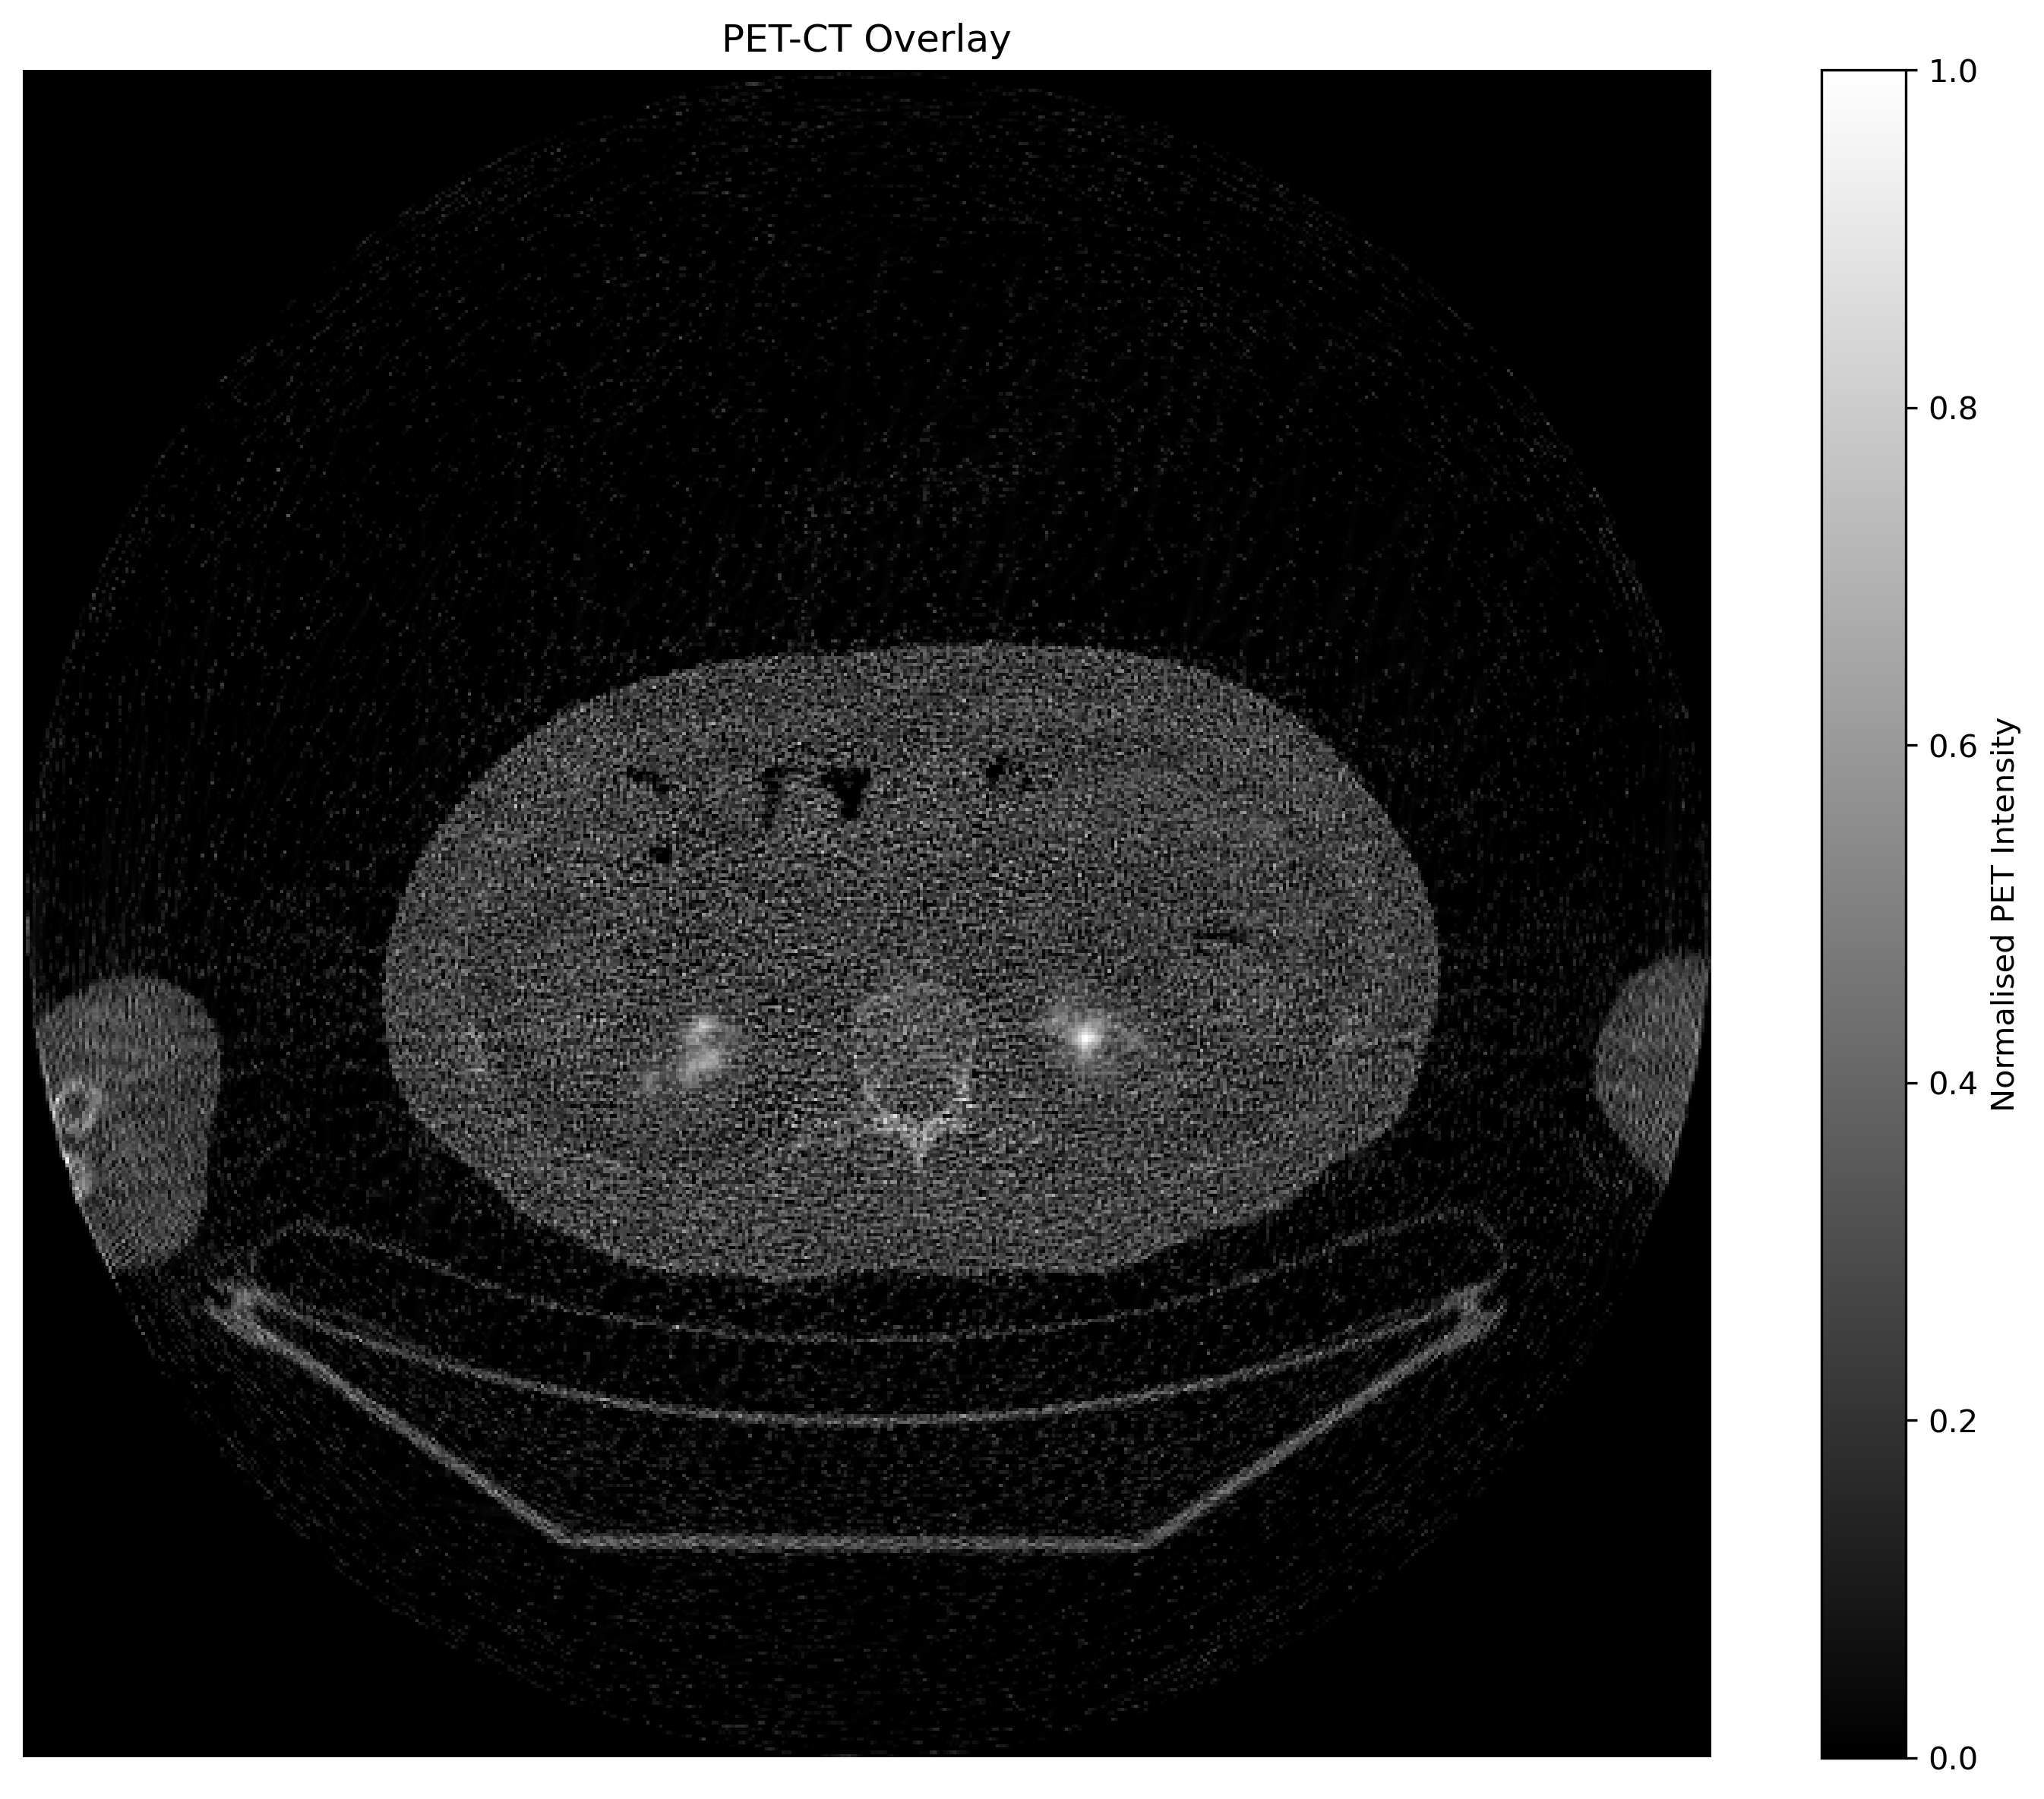

In [33]:
from skimage.transform import resize

ct_image = np.load(result_path/"ct_os_sart.npy")
pet_image = np.load(result_path/"pet_reconstruction_mlem.npy")

# confirm the same size
if pet_image.shape != ct_image.shape:
    pet_image = resize(pet_image, ct_image.shape, order=1, mode='constant', preserve_range=True)
                  
        
# normalise for display
ct_norm = (ct_image - np.min(ct_image)) / (np.max(ct_image) - np.min(ct_image))
pet_norm = (pet_image - np.min(pet_image)) / (np.max(pet_image) - np.min(pet_image))

plt.figure(figsize=(10, 8), dpi=300)

plt.imshow(ct_norm, cmap='gray', vmin=0, vmax=1)

plt.imshow(pet_norm, cmap='gray', alpha=1*pet_norm, vmin=0, vmax=1)

plt.colorbar(label='Normalised PET Intensity')
plt.title('PET-CT Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()